In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

In [5]:
### Read in observations ###
AllData = np.loadtxt('RAOBs.txt',dtype='str')

Lat = np.ones((np.size(AllData)))*np.nan
Lon = np.ones((np.size(AllData)))*np.nan
GeoHeight = np.ones((np.size(AllData)))*np.nan
WindDir = np.ones((np.size(AllData)))*np.nan
WindSpd = np.ones((np.size(AllData)))*np.nan

for i in range(0,np.size(AllData)):
    Data = AllData[i].split(',')
    Lat[i] = float(Data[1])
    Lon[i] = float(Data[2])
    GeoHeight[i] = float(Data[3])
    WindDir[i] = float(Data[4])
    WindSpd[i] = float(Data[5])

In [6]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0 = 18.9
y0 = -6.3
del_x = 1.27
del_y = 1.27
x = x0 + np.arange(22) * del_x
y = y0 + np.arange(28) * del_y
xg, yg = np.meshgrid(x,y)

In [9]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
rho = 6371
lambda0 = -115
lambda0_r = np.radians(lambda0)
phi0 = 60
phi0_r = np.radians(phi0)
map_scale = 1/15000000

Lat_r = np.radians(Lat)
Lon_r = np.radians(Lon)

xkm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.cos(Lon_r - lambda0_r))
ykm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.sin(Lon_r - lambda0_r))

xcm = xkm * 1E5
ycm = ykm * 1E5

xob = xcm * map_scale
yob = ycm * map_scale

yg_earth = yg / map_scale / 1E5
xg_earth = xg / map_scale / 1E5

Lat_g = np.degrees((np.pi/2) - 2*np.arctan( np.sqrt(xg_earth**2 + yg_earth**2) / (rho*(1+np.sin(phi0_r) ) )))
Lon_g = lambda0 + np.degrees(np.arctan(yg_earth/xg_earth))

ax1.scatter(Lon_g, Lat_g,transform=ccrs.PlateCarree(), marker ="*", color = 'green')
ax1.scatter(yob, xob, transform=ccrs.PlateCarree(), color = "purple")


In [6]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
roi = 10
obs_within_roi10cm = np.zeros(xg.shape)
analysis10cm = np.zeros(xg.shape)
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - xob 
        dy = ya - yob
        dik = np.sqrt(dx ** 2 + dy ** 2)
        ind_r = np.where(dik <= roi)
        xk = dx[ind_r]
        yk = dy[ind_r]
        fk = GeoHeight[ind_r]
        obs_within_roi10cm[i,j] = len(xk)
        xkb = np.mean(xk)
        ykb = np.mean(yk)
        xk2b = np.mean(xk*xk)
        yk2b = np.mean(yk*yk)
        xk3b = np.mean(xk*xk*xk)
        yk3b = np.mean(yk*yk*yk)
        xk4b = np.mean(xk*xk*xk*xk)
        yk4b = np.mean(yk*yk*yk*yk)
        xkbykb = np.mean(xk*yk)
        xkbyk2b = np.mean(xk*yk*yk)
        xk2bykb = np.mean(xk*xk*yk)
        xk2byk2b = np.mean(xk*xk*yk*yk)
        xk3bykb = np.mean(xk*xk*xk*yk)
        xkbyk3b = np.mean(xk*yk*yk*yk)
        
        fkb = np.mean(fk)
        xkbfkb = np.mean(xk*fk)
        ykbfkb = np.mean(yk*fk)
        xk2bfkb = np.mean(xk*xk*fk)
        yk2bfkb = np.mean(yk*yk*fk)
        xkbykbfkb = np.mean(xk*yk*fk)
        
        r_mat = np.matrix([
            [1,xkb,ykb,xk2b,yk2b,xkbykb],
            [xkb,xk2b,xkbykb,xk3b,xkbyk2b,xk2bykb],
            [ykb,xkbykb,yk2b,xk2bykb,yk3b,xkbyk2b],
            [xk2b,xk3b,xk2bykb,xk4b,xk2byk2b,xk3bykb],
            [yk2b,xkbyk2b,yk3b,xk2byk2b,yk4b,xkbyk3b],
            [xkbykb, xk2bykb,xkbyk2b,xk3bykb,xkbyk3b,xk2byk2b],            
        ])

        f_mat = np.matrix([
            [fkb],
            [xkbfkb],
            [ykbfkb],
            [xk2bfkb],
            [yk2bfkb],
            [xkbykbfkb]])

        coeff = np.linalg.inv(r_mat)*f_mat
        analysis10cm[i,j] = coeff[0]


C:\Users\squid\AppData\Local\Temp\ipykernel_22960\169754226.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  analysis10cm[i,j] = coeff[0]


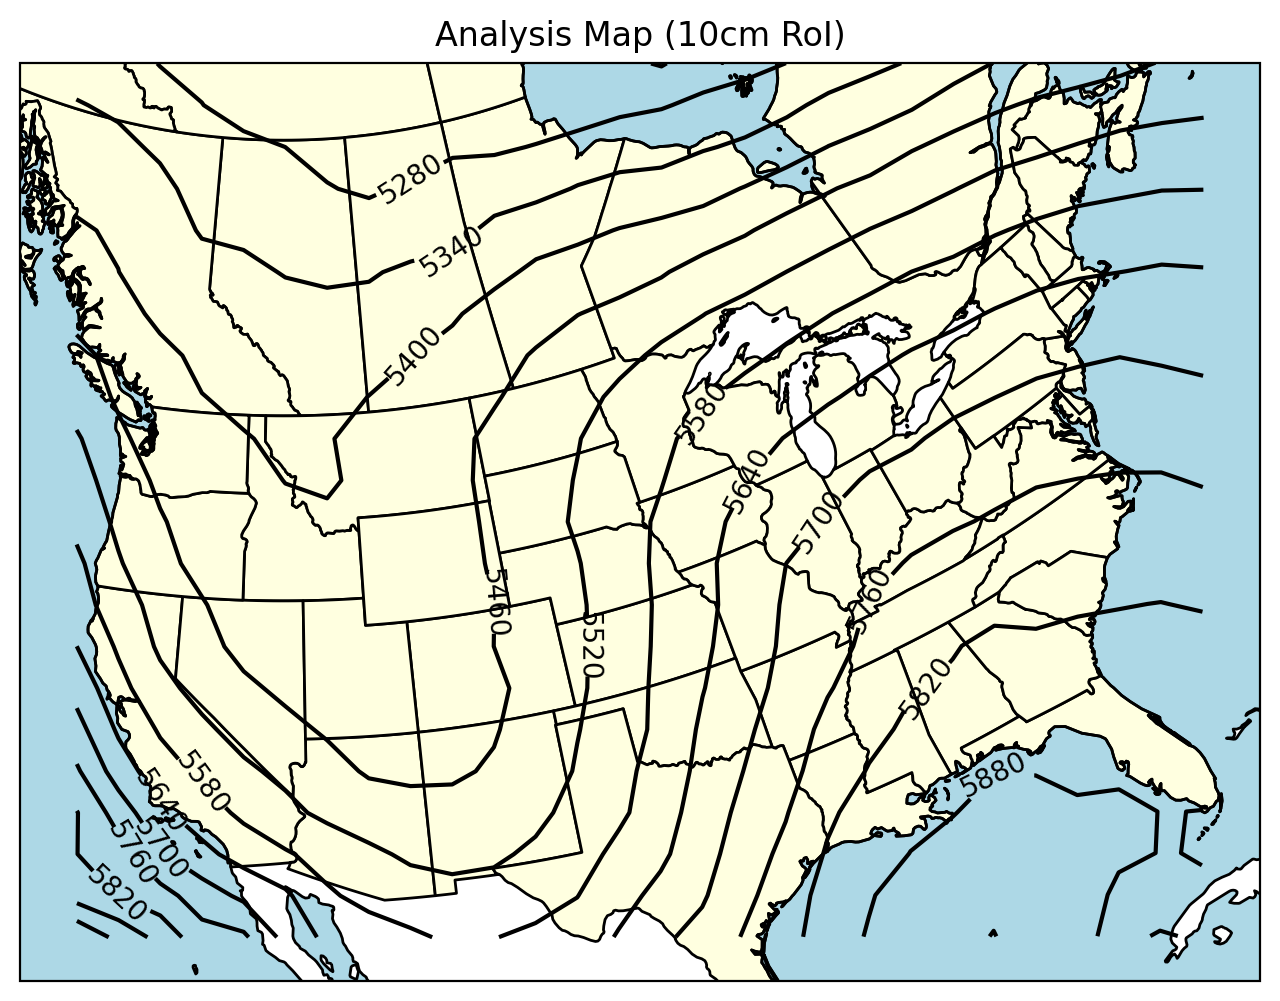

In [14]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g,analysis10cm,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (10cm RoI)')
plt.savefig("Analysis10cm.png", dpi = 250)

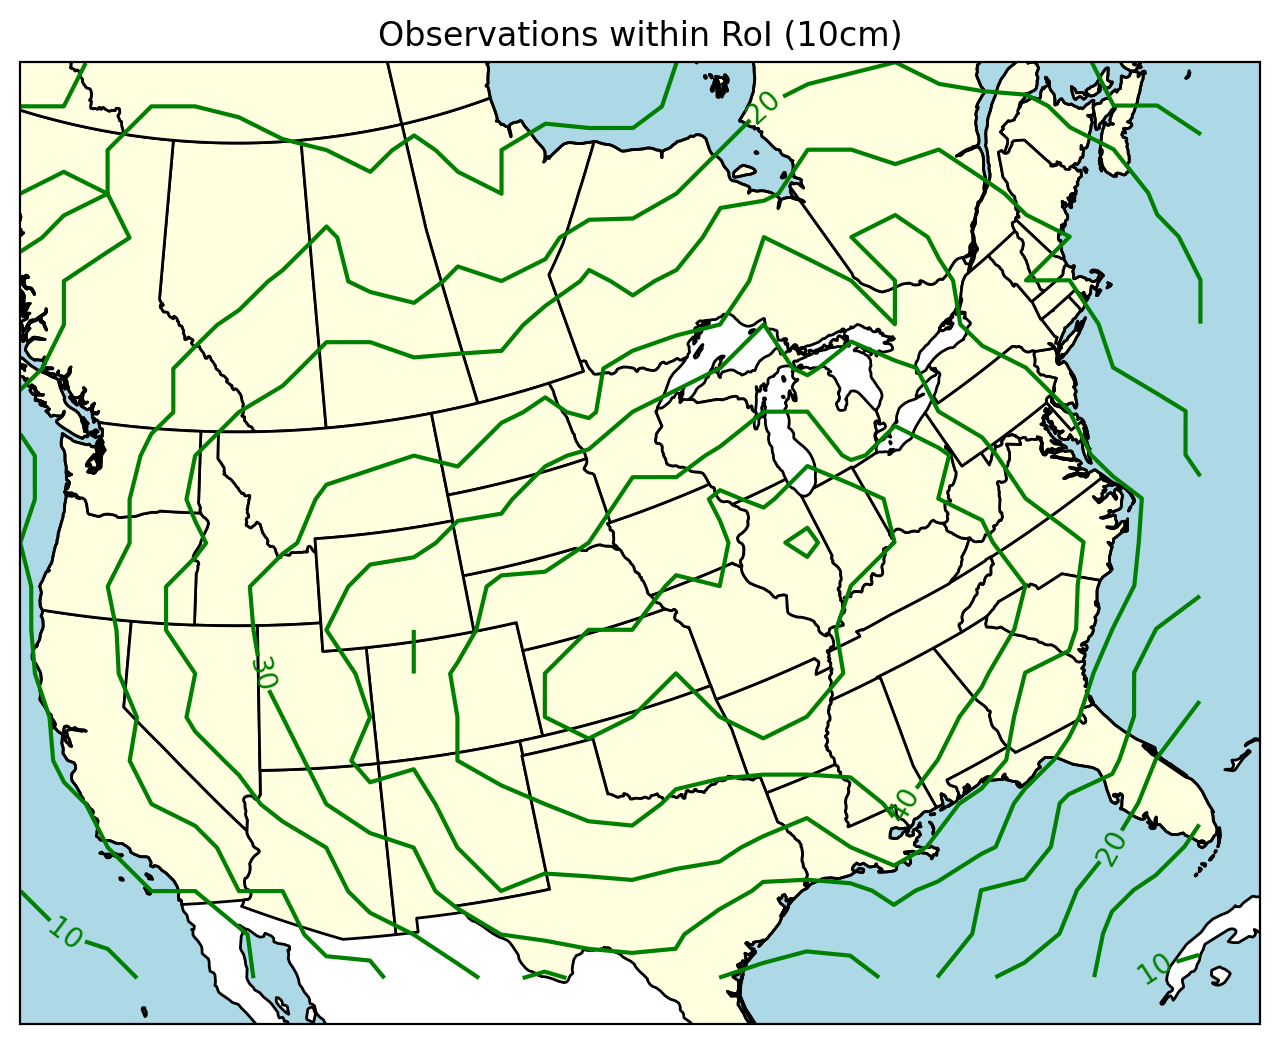

In [13]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g,obs_within_roi10cm[:,:],colors='green',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Observations within RoI (10cm)')
plt.savefig("Observations10cm.png", dpi=250)

In [8]:
roi = 20
obs_within_roi20cm = np.zeros(xg.shape)
analysis20cm = np.zeros(xg.shape)
for i in range(len(xg)):
    for j in range(len(xg[i])):
        xa = xg[i,j]
        ya = yg[i,j]
        dx = xa - xob 
        dy = ya - yob
        dik = np.sqrt(dx ** 2 + dy ** 2)
        ind_r = np.where(dik <= roi)
        xk = dx[ind_r]
        yk = dy[ind_r]
        fk = GeoHeight[ind_r]
        obs_within_roi20cm[i,j] = len(xk)
        xkb = np.mean(xk)
        ykb = np.mean(yk)
        xk2b = np.mean(xk*xk)
        yk2b = np.mean(yk*yk)
        xk3b = np.mean(xk*xk*xk)
        yk3b = np.mean(yk*yk*yk)
        xk4b = np.mean(xk*xk*xk*xk)
        yk4b = np.mean(yk*yk*yk*yk)
        xkbykb = np.mean(xk*yk)
        xkbyk2b = np.mean(xk*yk*yk)
        xk2bykb = np.mean(xk*xk*yk)
        xkbyk2b = np.mean(xk*yk*yk)
        xk2byk2b = np.mean(xk*xk*yk*yk)
        xk3bykb = np.mean(xk*xk*xk*yk)
        xkbyk3b = np.mean(xk*yk*yk*yk)

        fkb = np.mean(fk)
        xkbfkb = np.mean(xk*fk)
        ykbfkb = np.mean(yk*fk)
        xk2bfkb = np.mean(xk*xk*fk)
        yk2bfkb = np.mean(yk*yk*fk)
        xkbykbfkb = np.mean(xk*yk*fk)
        
        r_mat = np.matrix([
            [1,xkb,ykb,xk2b,yk2b,xkbykb],
            [xkb,xk2b,xkbykb,xk3b,xkbyk2b,xk2bykb],
            [ykb,xkbykb,yk2b,xk2bykb,yk3b,xkbyk2b],
            [xk2b,xk3b,xk2bykb,xk4b,xk2byk2b,xk3bykb],
            [yk2b,xkbyk2b,yk3b,xk2byk2b,yk4b,xkbyk3b],
            [xkbykb, xk2bykb,xkbyk2b,xk3bykb,xkbyk3b,xk2byk2b],            
        ])

        f_mat = np.matrix([
            [fkb],
            [xkbfkb],
            [ykbfkb],
            [xk2bfkb],
            [yk2bfkb],
            [xkbykbfkb]])

        coeff = np.linalg.inv(r_mat)*f_mat
        analysis20cm[i,j] = coeff[0]

C:\Users\squid\AppData\Local\Temp\ipykernel_22960\2538737807.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  analysis20cm[i,j] = coeff[0]


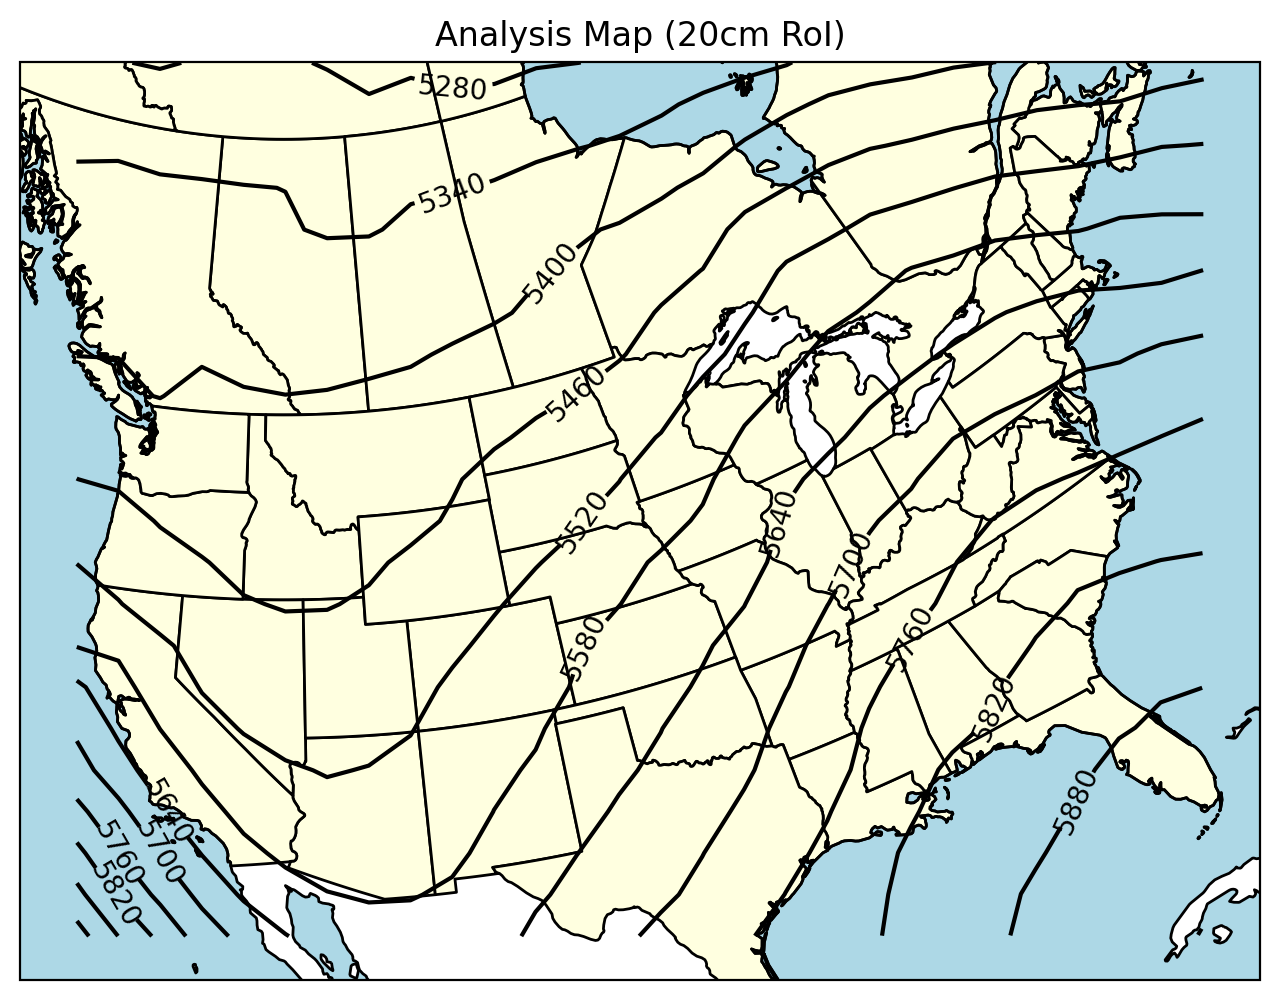

In [12]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g,analysis20cm,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (20cm RoI)')
plt.savefig("Analysis20cm.png", dpi=250)

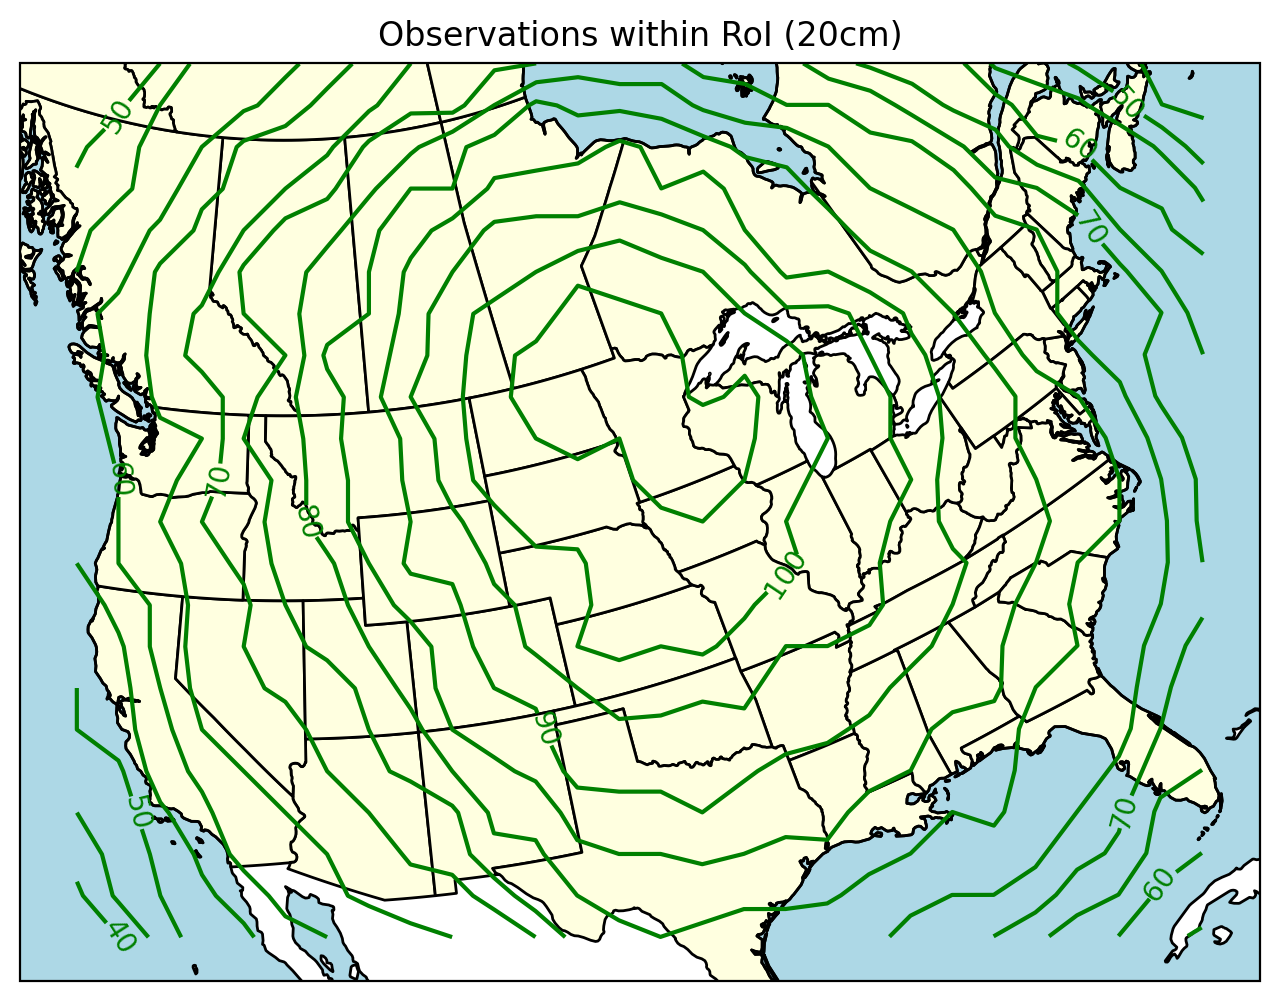

In [11]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g,obs_within_roi20cm[:,:],colors='green',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Observations within RoI (20cm)')
plt.savefig("Observations20cm.png", dpi=250)

In [35]:
### Store the analyses in text files ###
file1_10cm = open("10cm Analysis", "w+")
file1_20cm = open("20cm Analysis", "w+")
analysis_10cm = str(analysis10cm)
analysis_20cm = str(analysis20cm)
file1_10cm.write(analysis_10cm)
file1_20cm.write(analysis_20cm)
file1_10cm.close()
file1_20cm.close()

In [36]:
### Store the number of observations available for each grid point in text files ###
file2_10cm = open("Number of Obs for 10cm", "w+")
file2_20cm = open("Number of Obs for 20cm", "w+")
numobs10cm = str(obs_within_roi10cm)
numobs20cm = str(obs_within_roi20cm)
file2_10cm.write(numobs10cm)
file2_20cm.write(numobs20cm)
file2_10cm.close()
file2_20cm.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    - Both contoured analyses have a trough over the the western United States, with a ridge over the eastern US

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    - The trough in the 10cm analysis looks to be deeper than the in the 20cm one. 
    - In the 20cm analysis, the contours look much smoother, which would likely be because there are more observation available for each analysis point.
    
3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    - No, the analysis does not look realistic. 
    - The analysis has very, very tight contours over Canada, which would likely be caused by limited observation points within the RoI for each 
    anaysis point, which would produce the same analysis values over an area where there is only one observation within each RoI. 

4 - Suppose you ran this program with a small enough radius of influence that 
    only one observation was available for determining a polynomial fit at a grid
    point. Should you be able to perform the matrix inversion? Why or why not?
    - You would not be able to perform the matrix inversion because only having one observation per analysis point would produce a matrix with one row,
    which would be uninvertabe. 
    
'''